# Реализация алгоритма стохастического градиентного бустинга с
# квадратичной функцией потерь. В качестве базового алгоритма
# использовать алгоритм CART с RSM. ДЗ1

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets

import matplotlib.pylab as plt
%matplotlib inline

# CART implemention

In [2]:
class CART:    
    def __init__(self, features_rate, min_samples_leaf, max_depth):
        self.features_rate = features_rate
        self.tree_map = {}
        self.min_samples_leaf = min_samples_leaf
        if (max_depth == None):
            self.max_depth = 100000
        else:
            self.max_depth = max_depth

    def gen_tree(self, element_numbers, vertex_num, mean, now_depth, mse_value):
         
        if (now_depth == self.max_depth):  
            self.tree_map[str(vertex_num)] = [[None, None], [1], [mean], [None, None]]
            return 0
        
        min_mse = mse_value

        pos_num_split = np.nan
        value_split = np.nan
        
        left = []
        right = []
        
        cou_elements = len(element_numbers)
        
        best_left_square_sum = np.nan
        best_left_sum = np.nan
        best_right_square_sum = np.nan
        best_right_sum = np.nan
        
        x = self.x[element_numbers]
        y = self.y[element_numbers]

        for feature_num in range(self.features_cou_analize):

            sort_ind = x[:,feature_num].argsort()
            new_x = x[:,feature_num][sort_ind]
            new_y = y[sort_ind]
            
            left_cou = 0
            right_cou = cou_elements
            
            del_num = 0
            right_square_sum = mse_value + mean * mean * cou_elements * 1.0
            right_sum = mean * cou_elements * 1.0
            left_square_sum = 0.0
            left_sum = 0.0
            feature_value_split = np.nan
            for i, feature_value in enumerate(new_x):
                
                if (feature_value_split == feature_value):
                    continue
                    
                if (np.isnan(feature_value_split)):
                    feature_value_split = feature_value
                else:
                    feature_value_split = 0.5 * (feature_value_split + feature_value)
                    
                while (1):
                    if (new_x[del_num] < feature_value_split):
                        y_val = new_y[del_num]
                        del_num += 1
                        left_cou += 1
                        right_cou -= 1
                        
                        left_square_sum += y_val * y_val
                        left_sum += y_val
                        
                        right_square_sum -= y_val * y_val
                        right_sum -= y_val
                    else:
                        break
                
                if (left_cou < self.min_samples_leaf):
                    continue
                elif (right_cou < self.min_samples_leaf):
                    break
                
                now_left_mse = left_square_sum - left_sum * left_sum * 1.0/ left_cou
                now_right_mse = right_square_sum - right_sum * right_sum * 1.0 / right_cou
                
                if (now_left_mse + now_right_mse < min_mse):
                    min_mse = now_left_mse + now_right_mse
                    pos_num_split = feature_num
                    value_split = feature_value_split
                    
                    best_left_square_sum = left_square_sum
                    best_left_sum = left_sum
                    
                    best_right_square_sum = right_square_sum
                    best_right_sum = right_sum
                    
        if (np.isnan(value_split)):
            self.tree_map[str(vertex_num)]= [[None, None], [1], [mean], [None, None]]
            return 0
        
        self.tree_map[str(vertex_num)] = [[self.feature_order[pos_num_split], value_split], [0], [mean], [vertex_num*2 + 1, vertex_num*2 + 2]]
        
        
        left_class = []
        right_class = []
        
        for pos in element_numbers:
            if (self.x[pos][pos_num_split] < value_split):
                left.append(pos)
            else:
                right.append(pos)

        left_mse = best_left_square_sum - (best_left_sum ** 2.0) / len(left)
        right_mse = best_right_square_sum - (best_right_sum ** 2.0) / len(right)
        
        self.feature_contribution[self.feature_order[pos_num_split]] += (mse_value - left_mse - right_mse)
        
        self.gen_tree(left, vertex_num*2 + 1, best_left_sum * 1.0 / len(left), now_depth + 1, left_mse)
        self.gen_tree(right, vertex_num*2 + 2, best_right_sum *1.0/ len(right), now_depth + 1, right_mse)
        
    def fit(self, x, y):
        self.tree_map = {}
        
        x = np.asarray(x, dtype = np.float)
        features_cou = (x.shape)[1]
        self.feature_order = np.sort(np.random.choice((x.shape)[1], int((x.shape)[1] * (self.features_rate)), replace=False))
        
        self.features_cou_analize = int((x.shape)[1] * (self.features_rate))
        self.cou_samples = len(x)
        
        self.feature_contribution = np.zeros(features_cou)
        
        for i in reversed(range(features_cou)):
            if (i not in self.feature_order):
                x = np.delete(x, i, 1)

        self.x = x
        self.y = np.asarray(y, dtype = np.float)
        y_pred = np.tile(np.sum(y) * 1.0 / len(y), len(y))
        
        self.gen_tree(np.arange(self.cou_samples), 0, np.sum(y) * 1.0 / len(y), 0, np.sum((y_pred - self.y) ** 2.0))
        
        return self.tree_map

    def predict(self, data):
        y_pred = []
        for sample in data:
            now_vertex = 0
            while (1):
                if (self.tree_map[str(now_vertex)][1][0] == 1):
                    break
                if (sample[self.tree_map[str(now_vertex)][0][0]] >= self.tree_map[str(now_vertex)][0][1]):
                    now_vertex = self.tree_map[str(now_vertex)][3][1]
                else:
                    now_vertex = self.tree_map[str(now_vertex)][3][0]
            y_pred.append(self.tree_map[str(now_vertex)][2][0])
        return y_pred
        
        

# Load Data Wine

In [3]:
data = []
true_class = []
f = open("wine.data.txt", "r")
f = f.readlines()

for line in f:
    line = line.strip()
    line = line.split(',')
    true_class.append(line[0])
    del line[0]
    data.append(line)
shape_x = len(data)
shape_y = len(data[0])

data = np.asarray(data, dtype=np.float)
true_class = np.asarray(true_class, dtype = np.int)


# Cross Validation for CART

In [4]:
cou_folds = 6
kf = KFold(len(data), n_folds=cou_folds, shuffle=True)
my_tree = 0.0
sk_tree = 0.0
cart = CART(1.0, 1, None)

for train_index, test_index in kf:
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = true_class[train_index], true_class[test_index]
    cart.fit(x_train, y_train)
    y_pred = cart.predict(x_test)
    my_tree += sk.metrics.mean_squared_error(y_test, y_pred)
    print 'My mse', sk.metrics.mean_squared_error(y_test, y_pred)
    
    clf = tree.DecisionTreeRegressor(max_depth=None)
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    sk_tree += sk.metrics.mean_squared_error(y_test, y_pred)
    print 'sklearn mse', sk.metrics.mean_squared_error(y_test, y_pred)

print 'my_mean_mse', my_tree / cou_folds
print 'sk_mean_mse', sk_tree / cou_folds

My mse 0.0333333333333
sklearn mse 0.0333333333333
My mse 0.133333333333
sklearn mse 0.1
My mse 0.0333333333333
sklearn mse 0.0333333333333
My mse 0.1
sklearn mse 0.133333333333
My mse 0.0344827586207
sklearn mse 0.0344827586207
My mse 0.0344827586207
sklearn mse 0.0344827586207
my_mean_mse 0.0614942528736
sk_mean_mse 0.0614942528736


# STOCHASTIC GRADIENT BOOSTING

In [5]:
class Stochastic_gradient_boosting:
    
    def __init__(self, n_estimators, features_rate, cou_samples, min_samples_split, learning_rate, max_depth, loss):
        
        self.number_elements_in_subsample = cou_samples / n_estimators
        self.n_estimators = n_estimators
        self.features_rate = features_rate
        self.cou_samples = cou_samples
        self.loss = loss
        self.min_samples_split = min_samples_split
        self.shrinkage_value = learning_rate
        if (max_depth == None):
            self.max_depth = 10000
        else:
            self.max_depth = max_depth
    
    def get_predict_for_sample_and_one_tree(self, sample, tree_map):
        now_vertex = 0
        while (1):
            if (tree_map[str(now_vertex)][1][0] == 1):
                break
            if (sample[tree_map[str(now_vertex)][0][0]] >= tree_map[str(now_vertex)][0][1]):
                now_vertex = tree_map[str(now_vertex)][3][1]
            else:
                now_vertex = tree_map[str(now_vertex)][3][0]
        return tree_map[str(now_vertex)][2][0]
    
    def get_predict_for_sample(self, sample):
        answer = 0.0
        for i in range(len(self.trees_list)):
            answer += self.shrinkage_value * self.get_predict_for_sample_and_one_tree(sample, self.trees_list[i][1])
        return answer
    
    def update_grad_for_l2(self, x, tree_map):
        for i, sample in enumerate(x):
            self.now_grad[i] -= 2.0 * self.get_predict_for_sample_and_one_tree(sample, tree_map) * self.shrinkage_value
            
    def update_grad_for_l1(self, x, tree_map):
        for i, sample in enumerate(x):
            pred_for_sample = self.get_predict_for_sample_and_one_tree(sample, tree_map) * self.shrinkage_value
            self.y_balance[i] -= pred_for_sample
            if (self.y_balance[i] == 0.0):
                self.now_grad[i] = 0.00000001
            elif (self.y_balance[i] > 0.0):
                self.now_grad[i] = 1.0
            elif (self.y_balance[i] < 0.0):
                self.now_grad[i] = -1.0
        
        
    def predict_regression(self, x):
        y_pred = np.zeros(len(x))
        for i, sample in enumerate(x):
            y_pred[i] = self.get_predict_for_sample(sample)
        return y_pred
    
    def fit(self, x, y):
        self.pos_arr = np.arange(self.cou_samples)
        self.now_grad = np.array(y, dtype = np.float)
        self.trees_list = []
        self.y_balance = np.array(y, dtype = np.float)
        
        cart = CART(self.features_rate, self.min_samples_split, self.max_depth)
        
        self.feature_contribution = np.zeros((x.shape)[1])
        
        for i in range(self.n_estimators):
            np.random.shuffle(self.pos_arr)
            index = self.pos_arr[:self.cou_samples / 2]
            now_x = x[index]
            now_y = self.now_grad[index]
            
            cart.fit(now_x, now_y)
            if (i == 0 and self.loss == 'l2'):
                self.now_grad *= 2.0
            elif (i == 0 and self.loss == 'l1'):
                self.now_grad = np.zeros(len(self.now_grad))
                
            self.feature_contribution += cart.feature_contribution
            
            self.trees_list.append([self.shrinkage_value, cart.tree_map])
            
            if (self.loss == 'l2'):
                self.update_grad_for_l2(x, cart.tree_map)
            elif (self.loss == 'l1'):
                self.update_grad_for_l1(x, cart.tree_map)
                
        return self.trees_list

# Testing Stochastic Gradient Boosting on spam Dataset

# READ DATA

In [6]:
f = open("spam.train.txt", "r")
y_true = []
data = []
for line in f:
    line = line[:len(line) - 1]
    arr = line.split(' ')
    y_true.append(arr[0])
    del arr[0]
    data.append(arr)
data = np.asarray(data, dtype = np.float)
y_true = np.asarray(y_true, dtype = np.float)

In [7]:
f = open("spam.test.txt", "r")
test_data = []
test_y = []
for line in f:
    line = line[:len(line) - 1]
    arr = line.split(' ')
    test_y.append(arr[0])
    del arr[0]
    test_data.append(arr)
    
test_data = np.asarray(test_data, dtype = np.float)
test_y = np.asarray(test_y, dtype = np.float)

## Print plots

In [8]:
t1 = time.clock()
cou_samples = len(data)
original_params = {'n_estimators': 100, 'features_rate': 0.7, 'cou_samples': cou_samples, 'min_samples_split': 4,
                'learning_rate' : 0.03, 'max_depth' : 3, 'loss' : "l2"}

boosting_l2 = Stochastic_gradient_boosting(**original_params)
boosting_l2.fit(data, y_true)
y_pred = boosting_l2.predict_regression(test_data)
print 'Mse Error', sk.metrics.mean_squared_error(test_y, y_pred)
print time.clock() - t1

Mse Error 0.0665084082707
358.794888


In [9]:
t1 = time.clock()
estimators_list = np.linspace(30, 100, 8)
mse_sklearn = []
for cou_estimators in estimators_list:
    params = {'n_estimators': int(cou_estimators), 'max_depth': 3, 'min_samples_split': 4,
          'learning_rate': 0.03, 'loss': 'ls'}
    
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(data, y_true)
    y_pred = clf.predict(test_data)
    mse_sklearn.append(sk.metrics.mean_squared_error(test_y, y_pred))
print time.clock() - t1

63.48111


In [16]:
t1 = time.clock()
cou_samples = len(data)
original_params = {'n_estimators': 100, 'features_rate': 0.7, 'cou_samples': cou_samples, 'min_samples_split': 4,
                'learning_rate' : 0.03, 'max_depth' : 3, 'loss' : "l1"}

boosting_l1 = Stochastic_gradient_boosting(**original_params)
boosting_l1.fit(data, y_true)
y_pred = boosting_l1.predict_regression(test_data)
print time.clock() - t1

528.161966


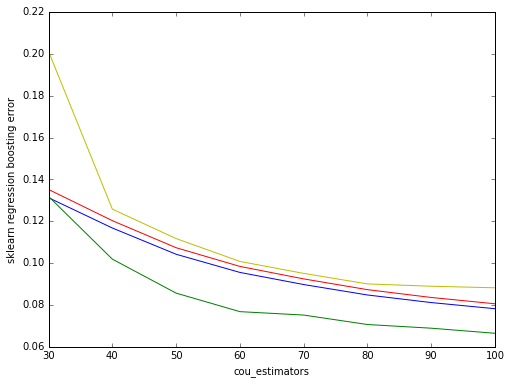

In [17]:
y = test_y.copy()
y1 = test_y.copy()
my_mse_for_l2 = []
my_mse_for_l1 = []
cou_samples = len(test_y)
y = np.array(y, dtype = np.float)
y1 = np.array(y1, dtype = np.float)
for i in range(0, 100):
    for j, sample in enumerate(test_data):
        y[j] -= boosting_l2.get_predict_for_sample_and_one_tree(sample, boosting_l2.trees_list[i][1]) * boosting_l2.shrinkage_value
        y1[j] -= boosting_l1.get_predict_for_sample_and_one_tree(sample, boosting_l1.trees_list[i][1]) * boosting_l1.shrinkage_value
    if (i + 1 in estimators_list):
        my_mse_for_l2.append(np.sum(y ** 2.0) * 1.0 / cou_samples)
        my_mse_for_l1.append(np.sum(y1 ** 2.0) * 1.0 / cou_samples)
    
    

        
mse_sklearn = np.asarray(mse_sklearn, dtype = np.float)
estimators_list = np.asarray(estimators_list, dtype = np.float)
plt.figure(figsize = (8, 6), dpi = 80)
plt.xlabel('cou_estimators')
plt.ylabel('sklearn regression boosting error')
plt.plot(estimators_list, mse_sklearn, 'b')
plt.plot(estimators_list, mse_sklearn * 1.03, c = 'r')
plt.plot(estimators_list, my_mse_for_l2, c = 'g')
plt.plot(estimators_list, my_mse_for_l1, c = 'y')
plt.show()

# Реализовать embedded метод отбора признаков для
# своего варианта из дз 1. Провести сравнительный анализ своего
# метода с каждым из подходов, описанных на лекции (т.е. нужно
# минимум реализовать один wrapper и один filter метод). Построить
# графики. ДЗ2

# Implemention embedded method

In [8]:
def emdedded_method(params, data, y_true, cou_features):
    t1 = time.clock()
    boosting = Stochastic_gradient_boosting(**params)
    boosting.fit(data, y_true)
    a = boosting.feature_contribution
    f_contrib = []
    for feature_num, feature_contribution in enumerate(a):
        f_contrib.append([feature_contribution, feature_num])
        
    f_contrib = sorted(f_contrib, reverse= True)
    f_contrib = np.asarray(f_contrib, dtype = np.float)
    
    result_positions = []
    for i in range(cou_features):
        result_positions.append(f_contrib[i][1])
    
    return result_positions, time.clock() - t1


In [9]:
params = {'n_estimators': 60, 'features_rate': 1.0, 'cou_samples': len(data), 'min_samples_split': 40,
                    'learning_rate' : 0.06, 'max_depth' : 5, 'loss' : 'l2'}
cou_features = (data.shape)[1] - 15
features_embedded, time_embedded = emdedded_method(params, data, y_true, cou_features)

In [10]:
print features_embedded, time_embedded

[48.0, 101.0, 70.0, 49.0, 10.0, 17.0, 8.0, 53.0, 35.0, 71.0, 9.0, 16.0, 4.0, 31.0, 73.0, 41.0, 15.0, 52.0, 29.0, 38.0, 56.0, 43.0, 32.0, 47.0, 14.0, 75.0, 76.0, 19.0, 37.0, 83.0, 50.0, 55.0, 27.0, 33.0, 12.0, 100.0, 3.0, 42.0, 11.0, 39.0, 5.0, 21.0, 40.0, 13.0, 74.0, 26.0, 18.0, 22.0, 54.0, 24.0, 51.0, 91.0, 87.0, 80.0, 30.0, 72.0, 6.0, 23.0, 96.0, 20.0, 7.0, 62.0, 81.0, 28.0, 95.0, 93.0, 78.0, 46.0, 79.0, 82.0, 84.0, 86.0, 0.0, 1.0, 44.0, 90.0, 25.0, 88.0, 61.0, 45.0, 99.0, 98.0, 97.0, 94.0, 92.0, 89.0, 85.0] 452.959199


# Implemention Wrapper method

In [11]:
def forward_selection(data, y_true, hopelessness_value, loss):
    start_time = time.clock()
    
    data = np.asarray(data, np.float)
    y_true = np.asarray(y_true, np.float)
    
    features_set = []
    features_cou = (data.shape)[1]
    Q = 100000.0
    for i in range(features_cou):
        best_feature = -1
        for j in range(features_cou):
            now_x = data.copy()
            if (j not in features_set):
                now_set = list(features_set)
                now_set.append(j)
                for del_pos in reversed(range(features_cou)):
                    if (del_pos not in now_set):
                        now_x = np.delete(now_x, del_pos, axis = 1)
            else:
                continue
                

            cou_folds = 5
            kf = KFold(len(data), n_folds=cou_folds, shuffle=True)
            mse_value_for_now_feature = 0.0
            for train_index, test_index in kf:
                x_train, x_test = now_x[train_index], now_x[test_index]
                y_train, y_test = y_true[train_index], y_true[test_index]
                
                params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 4,
                      'learning_rate': 0.05, 'loss': 'ls'}
                
                clf = ensemble.GradientBoostingRegressor(**params)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_test)
                mse_value_for_now_feature += sk.metrics.mean_squared_error(y_test, y_pred)

            
            mse_value_for_now_feature /= cou_folds
            if (mse_value_for_now_feature < Q * hopelessness_value):
                Q = mse_value_for_now_feature
                best_feature = j
        if (best_feature == -1):
            break
        features_set.append(best_feature)
    return features_set, time.clock() - start_time

In [12]:
features_forward_selection, time_forward_selection = forward_selection(data, y_true, 0.9, "l2")

In [13]:
print features_forward_selection, time_forward_selection

[48, 4, 8, 9, 10, 42, 70] 1352.676861


# Corelation Feature Selection implement

In [14]:
def corelation_feature_selection(x, y):
    start_time = time.clock()
    features_cou = (x.shape)[1]
    samples_cou = len(y)
    corelation_target = np.zeros(features_cou, dtype = np.float)
    pair_feature_corelation = np.zeros(shape = (features_cou, features_cou))
    y_mean = np.tile(np.sum(y) / samples_cou, samples_cou)
    
    for pos in range(features_cou):    
        now_feature = x[:,pos]
        now_feature_mean = np.tile(np.sum(now_feature) / samples_cou, samples_cou)
        corelation_target[pos] = np.sum((y - y_mean) * (now_feature - now_feature_mean)) / np.sqrt(np.sum((y - y_mean) ** 2) * np.sum((now_feature - now_feature_mean) ** 2))
    
    for first_pos in range(features_cou):
        first_feature = x[:, first_pos]
        first_feature_mean = np.tile(np.sum(first_feature) / samples_cou, samples_cou)
        for second_pos in range(features_cou):
            second_feature = x[:, second_pos]
            second_feature_mean = np.tile(np.sum(second_feature) / samples_cou, samples_cou)
            pair_feature_corelation[first_pos][second_pos] = np.sum((first_feature - first_feature_mean) * (second_feature - second_feature_mean))/ np.sqrt(np.sum((first_feature - first_feature_mean) ** 2) * np.sum((second_feature - second_feature_mean) ** 2))
            
    features_set = []
    
    best_nominator = 0.0
    best_denominator = 0.0
    now_nominator = 0.0
    now_denominator = 0.0
    best_value = 0.0
    
    for i in range(features_cou):
        best_pos = -1
        now_nominator = 0.0
        now_denominator = 0.0
        
        for pos in range(features_cou):
            if (pos not in features_set):
                now_nominator = best_nominator + corelation_target[pos]
                now_denominator = np.sqrt(best_denominator ** 2 + 1 + 2.0 * np.sum(pair_feature_corelation[pos][features_set]))
            else:
                continue
                
            if ((now_nominator / now_denominator) > best_value):
                best_value = now_nominator / now_denominator
                best_pos = pos
        if (best_pos == -1):
            break
        best_nominator = best_nominator + corelation_target[best_pos]
        best_denominator = np.sqrt(best_denominator ** 2 + 1 + 2.0 * np.sum(pair_feature_corelation[best_pos][features_set]))
        features_set.append(best_pos)
        
    return features_set, time.clock() - start_time

In [15]:
feature_corelation_selection, time_corelation_selection = corelation_feature_selection(data, y_true)

# Print Plots 

## Find best count features for embedded method, best score - 31 features

690.348243


/home/alex/.pyenv/versions/2.7.10/envs/sphere_mail/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/alex/.pyenv/versions/2.7.10/envs/sphere_mail/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


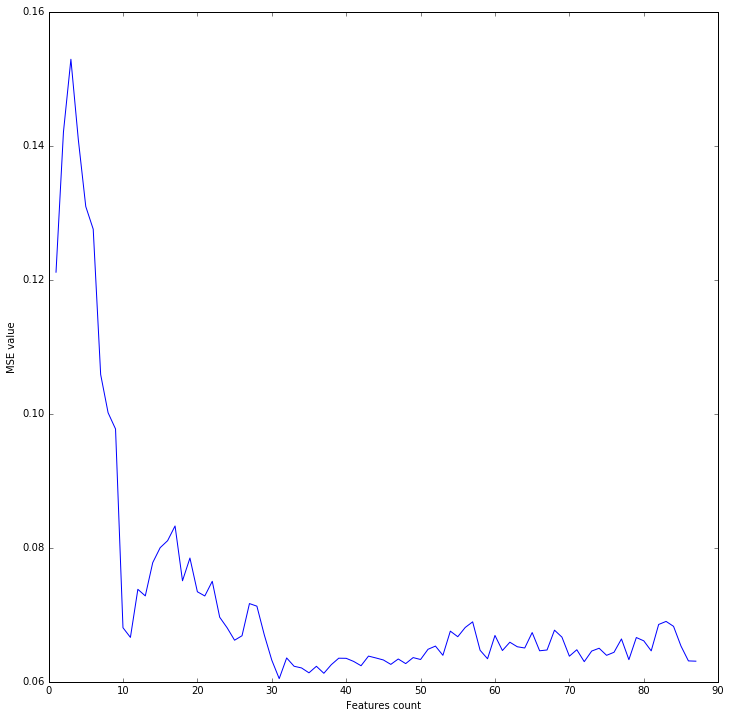

In [16]:
start_time = time.clock()
params = {'n_estimators': 120, 'max_depth': 4, 'min_samples_split': 4,
                      'learning_rate': 0.05, 'loss': 'ls'}
Y = []
X = np.linspace(1, cou_features, cou_features)
for i in range(cou_features):
    #print i
    now_x = data[:,features_embedded[0:i + 1]]
    now_y = y_true
    test_x = test_data[:,features_embedded[0:i+1]]
    clf = sk.ensemble.GradientBoostingRegressor(**params)
    clf.fit(now_x, now_y)
    y_pred = clf.predict(test_x)
    #boosting = Stochastic_gradient_boosting(**params)
    #boosting.fit(now_x, now_y)
    #y_pred = boosting.predict_regression(test_data)
    Y.append(sk.metrics.mean_squared_error(y_pred, test_y))

print time.clock() - start_time
plt.figure(figsize = (12, 12), dpi = 80)
plt.plot(X, Y, c = 'b')
plt.xlabel("Features count")
plt.ylabel("MSE value")
plt.show()

In [19]:
features_embedded = features_embedded[0:32]
print features_embedded

[48.0, 101.0, 70.0, 49.0, 10.0, 17.0, 8.0, 53.0, 35.0, 71.0, 9.0, 16.0, 4.0, 31.0, 73.0, 41.0, 15.0, 52.0, 29.0, 38.0, 56.0, 43.0, 32.0, 47.0, 14.0, 75.0, 76.0, 19.0, 37.0, 83.0, 50.0, 55.0]


## Get plot for embedde method

In [21]:
print test_data.shape
print test_x.shape

(10056, 102)
(10056, 87)


In [22]:
t1 = time.clock()
cou_samples = len(data)
original_params = {'n_estimators': 300, 'features_rate': 1.0, 'cou_samples': cou_samples, 'min_samples_split': 4,
                'learning_rate' : 0.03, 'max_depth' : 3, 'loss' : "l2"}

now_x = data[:,features_embedded]
now_y = y_true
test_x = test_data[:,features_embedded]

boosting_l2 = Stochastic_gradient_boosting(**original_params)
boosting_l2.fit(now_x, now_y)
y_pred = boosting_l2.predict_regression(test_x)
#print 'Mse Error', sk.metrics.mean_squared_error(test_y, y_pred)
print time.clock() - t1

648.939671


/home/alex/.pyenv/versions/2.7.10/envs/sphere_mail/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/alex/.pyenv/versions/2.7.10/envs/sphere_mail/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


In [23]:
estimators_list = np.linspace(1, 300, 300)

In [24]:
y = test_y.copy()
mse_for_embedded_method = []
cou_samples = len(test_y)
y = np.array(y, dtype = np.float)

for i in range(0, 300):
    for j, sample in enumerate(test_x):
        y[j] -= boosting_l2.get_predict_for_sample_and_one_tree(sample, boosting_l2.trees_list[i][1]) * boosting_l2.shrinkage_value
    if (i + 1 in estimators_list):
        mse_for_embedded_method.append(np.sum(y ** 2.0) * 1.0 / cou_samples)


## Get plot for Wrapper method

In [25]:
t1 = time.clock()
cou_samples = len(data)
original_params = {'n_estimators': 300, 'features_rate': 1.0, 'cou_samples': cou_samples, 'min_samples_split': 4,
                'learning_rate' : 0.03, 'max_depth' : 3, 'loss' : "l2"}

now_x = data[:,features_forward_selection]
now_y = y_true
test_x = test_data[:,features_forward_selection]

boosting_for_forward_selection = Stochastic_gradient_boosting(**original_params)
boosting_for_forward_selection.fit(now_x, now_y)
y_pred = boosting_for_forward_selection.predict_regression(test_x)
#print 'Mse Error', sk.metrics.mean_squared_error(test_y, y_pred)
print time.clock() - t1

189.774108


In [26]:
y = test_y.copy()
mse_for_forward_selection = []
cou_samples = len(test_y)
y = np.array(y, dtype = np.float)

for i in range(0, 300):
    for j, sample in enumerate(test_x):
        y[j] -= boosting_for_forward_selection.get_predict_for_sample_and_one_tree(sample, boosting_for_forward_selection.trees_list[i][1]) * boosting_for_forward_selection.shrinkage_value
    if (i + 1 in estimators_list):
        mse_for_forward_selection.append(np.sum(y ** 2.0) * 1.0 / cou_samples)

## Get plot for Corelation Feature Selection method 

In [27]:
t1 = time.clock()


now_x = data[:,feature_corelation_selection]
now_y = y_true
test_x = test_data[:,feature_corelation_selection]

boosting_for_CFS = Stochastic_gradient_boosting(**original_params)
boosting_for_CFS.fit(now_x, now_y)
y_pred = boosting_for_CFS.predict_regression(test_x)
print time.clock() - t1

166.025781


In [28]:
y = test_y.copy()
mse_for_CFS = []
cou_samples = len(test_y)
y = np.array(y, dtype = np.float)

for i in range(0, 300):
    for j, sample in enumerate(test_x):
        y[j] -= boosting_for_CFS.get_predict_for_sample_and_one_tree(sample, boosting_for_CFS.trees_list[i][1]) * boosting_for_CFS.shrinkage_value
    if (i + 1 in estimators_list):
        mse_for_CFS.append(np.sum(y ** 2.0) * 1.0 / cou_samples)

## Print plots

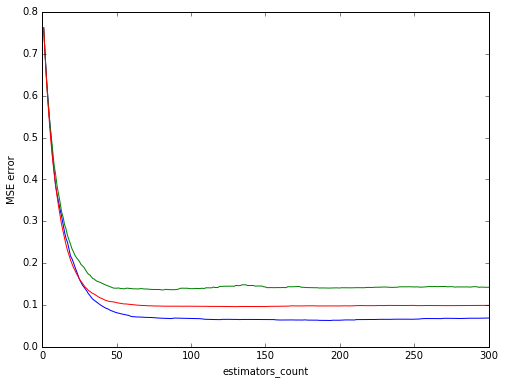

In [29]:
plt.figure(figsize = (8, 6), dpi = 80)
plt.plot(estimators_listtimators_list, mse_for_embedded_method, c = 'b')
plt.plot(estimators_list, mse_for_forward_selection, c = 'g')
plt.plot(estimators_list, mse_for_CFS, c = 'r')
plt.xlabel("estimators_count")
plt.ylabel("MSE error")
plt.show()